##### 该脚本从零开始实现一个线性支持向量机分类器，并封装成sklearn中的estimator形式。（使用Batch Gradient Descent进行训练）

准备工作：

①HyperParams：soft margin 程度系数C; 学习率和decay eta0, eta_d; 训练epoch数：n_epochs

②对象应有属性：常数项intercept_; 权重矩阵coef_; 支持向量 support_vectors_

③计算公式：

理论上: t_i = +1 或 -1.这里使用的二分类标签为0或1，所以t_i:

      t_i = 2 * y-1, 其中y为每一个instance的标签

Loss 函数：

L = 1/2 * w.T * w - C * ∑α_i * [t_i (w*x_i+b)-1] , 其中α_i只有在x_i为支持向量时才不为零

注意：这里当x_i为支持向量时，令KKT multiplier (α_i)值为1.否则为0. 为什么可以这样处理？？？？？？？？？？？？？？？？

  ==> 即： Loss = 1/2 * w.T.dot(w) + C * (np.sum(1-ti * X_support.dot(w)) - b * np.sum(t_support) )
Gradient:

dL/dw = w - C *  ∑α_i * t_i * x_i

dL/db = -C * ∑α_i * t_i

In [59]:
from sklearn.base import BaseEstimator
class My_SVC(BaseEstimator):
    def __init__(self, C = 1, eta0 = 1, eta_d = 10000, n_epochs = 1000, random_state = None):
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.random_state = random_state
    def eta(self, epoch):
        return self.eta0/(epoch + self.eta_d)
    def fit(self, X, y):
        C = self.C
        # 随机初始化一个w
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1)
        b = 0
        t = 2*y-1
        X_t = X*t #先把X和y_i对应乘起来
        self.loss_history = []
        for epoch in range(self.n_epochs):
            # 求出在当前w下的支持向量x_support
            support_vector_ind = (X_t.dot(w)+b*t < 1).ravel()
            X_t_sv = X_t[support_vector_ind]
            t_sv = t[support_vector_ind]
            # 求loss和gradient
            Loss = 1/2 * w.T.dot(w) + C * (np.sum(1-X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.loss_history.append(Loss)
            dw = w - C * np.sum(X_t_sv, axis = 0).reshape(-1, 1)        #注意w[mx1]，所以对x_reshape成[1xm]才能相减
            db = -C * np.sum(t_sv)
            lr = self.eta(epoch)
            w = w - lr * dw
            b = b - lr * db
        self.coef_ = w
        self.intercept_ = b
        self.support_ = ((X.dot(w) + b)* t < 1).ravel()
        self.support_vector_ = X[((X.dot(w) + b)* t < 1).ravel()]
        
    def decision_function(self, X):
        return X.dot(self.coef_)+self.intercept_
    def predict(self, X):
        return (self.decision_function(X)>0).astype(np.float64)
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X = iris['data'][:,(2,3)]
y = (iris['target']==2).astype(np.float64).reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2)

In [88]:
svm_clf = My_SVC(C = 2, eta0 = 10, n_epochs=10000, eta_d = 1000, random_state=42)
svm_clf.fit(X_train, y_train)
result = svm_clf.predict(X_test)
print('测试集准确率：',np.mean(result==y_test))
print(svm_clf.loss_history[0])
print(svm_clf.loss_history[0][0])
print(svm_clf.loss_history[0][0][0])
# from tkinter import _flatten
# loss_history = _flatten(svm_clf.loss_history)
np.squeeze(svm_clf.loss_history)

测试集准确率： 1.0
[[353.87712139]]
[353.87712139]
353.8771213947418


array([ 353.87712139, 2291.84064528,  504.17663001, ...,   30.50183969,
         30.54066999,   30.55425586])

[0, 10000, 0, 100]

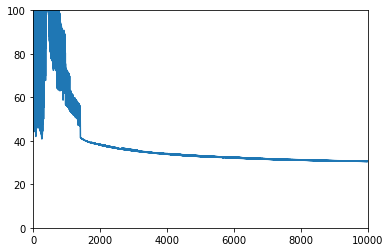

In [86]:
import matplotlib.pyplot as plt
plt.plot(range(svm_clf.n_epochs), np.squeeze(svm_clf.loss_history))
plt.axis([0, svm_clf.n_epochs, 0, 100])
# 可见：随机初始化导致训练前期loss曲线很奇怪...